## Image feature extraction

In [2]:

from dgl.nn import SAGEConv
import dgl.function as fn
from umap.umap_ import UMAP
from sklearn.metrics import roc_auc_score
import dgl
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import json
import gzip
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import dgl.data
import os
import random
import datetime
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from util import *

In [4]:
from mlflow import log_metric, log_param, log_artifact
import mlflow.sklearn
import mlflow.xgboost


from mlflow.tracking import MlflowClient


In [5]:
remote_server_uri = "http://127.0.0.1:5000/"  # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
experiment_name = 'Men_Clothing_Image_recommendation_v3'

mlflow.set_experiment(experiment_name)
# Forcing an end_run() to prevent 
#    https://github.com/mlflow/mlflow/issues/1335 
#    https://github.com/mlflow/mlflow/issues/608

mlflow.autolog()

artifact_path = mlflow.get_artifact_uri()
uri = mlflow.tracking.get_tracking_uri()
print(artifact_path)
print(uri)
mlflow.end_run()

2025/02/22 12:27:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/02/22 12:27:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/02/22 12:27:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/02/22 12:27:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/02/22 12:27:07 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This ini

mlflow-artifacts:/473744221893913913/e83838f934d14798b0f73b75c235766a/artifacts
http://127.0.0.1:5000/


In [6]:
from mlflow.tracking import MlflowClient
client = MlflowClient(mlflow.get_tracking_uri())


In [7]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

cuda
Num GPUs Available:  1


In [8]:
nodes = pd.read_parquet(f'../Dataset/nodes_without_image.parquet',engine='pyarrow')
edges = pd.read_parquet(f'../Dataset/edges_without_image.parquet',engine='pyarrow')

## Best model results

In [9]:
from util import *

In [10]:
from PIL import Image 
import matplotlib.pyplot as plt


In [11]:
def load_graph(run_id,artifact_name):
    artifact_uri = mlflow.get_run(run_id).info.artifact_uri
    # artifact_uri = f'{artifact_uri}/{artifact_name}'
    artifact_path_local = mlflow.artifacts.download_artifacts(f'{artifact_uri}/{artifact_name}')
    # with open(artifact_path_local, "rb") as f:
    loaded_graph = torch.load(artifact_path_local)
    return loaded_graph

def load_model(run_id,artifact_name):
    artifact_uri = mlflow.get_run(run_id).info.artifact_uri
    # artifact_uri = f'{artifact_uri}/{artifact_name}'
    artifact_path_local = mlflow.artifacts.download_artifacts(f'{artifact_uri}/{artifact_name}')
    loaded_model = torch.load(artifact_path_local)
    return loaded_model

In [12]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

import numpy as np

def mean_reciprocal_rank(actual, predicted):
    """
    Computes Mean Reciprocal Rank (MRR).
    
    Parameters:
    - actual: List of sets containing relevant items for each query.
    - predicted: List of lists containing ranked recommendations.
    
    Returns:
    - MRR score
    """
    reciprocal_ranks = []
    
    for act, pred in zip(actual, predicted):
        for rank, item in enumerate(pred, start=1):
            if item in act:
                reciprocal_ranks.append(1.0 / rank)
                break
        else:
            reciprocal_ranks.append(0.0)  # No relevant item found
    
    return np.mean(reciprocal_ranks)

# Example usage:
actual_items = [{101, 202, 303}, {404, 505}, {606, 707, 808}]
predicted_items = [[101, 505, 707, 909], [202, 505, 303, 606], [303, 606, 707, 101]]

print(f"MRR: {mean_reciprocal_rank(actual_items, predicted_items):.4f}")

def recall_at_k(actual, predicted, k=10):
    """
    Computes Recall@K.
    Recall@K = (Relevant Items Retrieved) / (Total Relevant Items)
    
    Parameters:
    - actual: List of sets containing relevant items for each query.
    - predicted: List of lists containing top-K recommended items.
    - k: Number of recommendations to consider.
    
    Returns:
    - Average Recall@K score
    """
    recall_scores = []
    for act, pred in zip(actual, predicted):
        if not act:
            continue  # Skip empty ground truth cases
        recall_scores.append(len(set(pred[:k]) & set(act)) / len(act))
    return np.mean(recall_scores)

def precision_at_k(actual, predicted, k=10):
    """
    Computes Recall@K.
    Recall@K = (Relevant Items Retrieved) / (Total Relevant Items)
    
    Parameters:
    - actual: List of sets containing relevant items for each query.
    - predicted: List of lists containing top-K recommended items.
    - k: Number of recommendations to consider.
    
    Returns:
    - Average Recall@K score
    """
    recall_scores = []
    for act, pred in zip(actual, predicted):
        if not act:
            continue  # Skip empty ground truth cases
        recall_scores.append(len(set(pred[:k]) & set(act)) / k)
    return np.mean(recall_scores)
import numpy as np

def dcg_at_k(relevance, k):
    """
    Computes Discounted Cumulative Gain (DCG) at K.

    Parameters:
    - relevance: List of relevance scores (binary or graded) for recommended items.
    - k: Rank threshold.

    Returns:
    - DCG@K score.
    """
    relevance = np.array(relevance)[:k]
    return np.sum((2**relevance - 1) / np.log2(np.arange(1, len(relevance) + 1) + 1))

def ndcg_at_k(actual, predicted, k=10):
    """
    Computes Normalized Discounted Cumulative Gain (NDCG) at K.

    Parameters:
    - actual: List of sets containing relevant items for each query.
    - predicted: List of lists containing ranked recommendations.
    - k: Rank threshold.

    Returns:
    - NDCG@K score.
    """
    ndcg_scores = []
    for act, pred in zip(actual, predicted):
        relevance = [1 if item in act else 0 for item in pred[:k]]  # Binary relevance
        dcg = dcg_at_k(relevance, k)
        idcg = dcg_at_k(sorted(relevance, reverse=True), k)  # Ideal DCG
        ndcg_scores.append(dcg / idcg if idcg > 0 else 0)
    
    return np.mean(ndcg_scores)

def hit_rate_at_k(actual, predicted, k=10):
    hits = [1 if len(set(pred[:k]) & set(act)) > 0 else 0 for act, pred in zip(actual, predicted)]
    return np.mean(hits)

MRR: 0.6667


In [ ]:
def print_eval(actual_items,predicted_items,k=100):
    print(f'recall_at_{k} = {recall_at_k(actual_items,predicted_items,k)}')
    print(f'precision_at_{k} = {precision_at_k(actual_items,predicted_items,k)}')
    print(f'mapk_at_{k} = {mapk(actual_items,predicted_items,k)}')
    print(f'mean_reciprocal_rank_at_{k} = {mean_reciprocal_rank(actual_items,predicted_items)}')
    print(f'ndcg_at_{k} = {ndcg_at_k(actual_items,predicted_items,k)}')
    print(f'hit_rate_at_{k} = {hit_rate_at_k(actual_items,predicted_items,k)}')



In [ ]:
def get_eval_score(actual_items,predicted_items,k=100):
    return {
        f'recall_at_{k}':recall_at_k(actual_items,predicted_items,k),
        f'precision_at_{k}' : precision_at_k(actual_items,predicted_items,k),
    f'mapk_at_{k}' : mapk(actual_items,predicted_items,k),
    f'mean_reciprocal_rank_at_{k}' : mean_reciprocal_rank(actual_items,predicted_items),
    f'ndcg_at_{k}' : ndcg_at_k(actual_items,predicted_items,k),
    f'hit_rate_at_{k}' : hit_rate_at_k(actual_items,predicted_items,k)}


KNN Results: {'Precision@100': 0.005738474279930064, 'Recall@100': 0.0674605440246346, 'Hit Rate@100': 0.09137756510536486, 'MAP@100': 0.01587105412282631, 'MRR': 0.017534017351285944, 'NDCG@100': 0.0390584798541975}


SVD Results: {'Precision@100': 0.007150087420631269, 'Recall@100': 0.15478795034060572, 'Hit Rate@100': 0.19655838777951595, 'MAP@100': 0.02054877728570036, 'MRR': 0.025374175513046625, 'NDCG@100': 0.06231418692043661}

In [15]:
run_ids = [('no data','18bdfbcf37044da698769f4ffe64824e'),('only ndata','570aa5ff8aff4a359ae1243bd179c575'),('only_image','7e1e21642e504fe4a81873be2e6ea296'),('all features','30b2f998d44e456ab2306e1418941a57')]

In [ ]:
run_ids = [('no data','18bdfbcf37044da698769f4ffe64824e'),('only ndata','570aa5ff8aff4a359ae1243bd179c575'),('only_image','7e1e21642e504fe4a81873be2e6ea296'),('all features','30b2f998d44e456ab2306e1418941a57')]
for name,run_id in run_ids:
    # print("name")
    graph_loaded = load_graph(run_id,'graph.pkl')
    # model_uri = "runs:/{}/model".format('587a0087e58d48fca0e9c5947e814355')
    loaded_model = load_model(run_id,'model.pkl')
    test_graph_loaded = load_model(run_id,'test_g.pkl')
    test_pos_loaded = load_model(run_id,'test_pos_g.pkl')
    test_neg_loaded = load_model(run_id,'test_neg_g.pkl')    
    test_graph_loaded = test_graph_loaded.to(device)
    test_pos_loaded = test_pos_loaded.to(device)
    test_neg_loaded = test_neg_loaded.to(device)
    graph_loaded = graph_loaded.to(device)
    pred = DotPredictor()
    torch.manual_seed(0)
    with torch.no_grad():
        loaded_model.eval()
        h_test = loaded_model(test_graph_loaded, test_graph_loaded.ndata['feat'].to(device))
        pos_score = pred(test_pos_loaded, h_test)
        neg_score = pred(test_neg_loaded, h_test)
        auc_score = compute_auc(pos_score, neg_score)
        print(auc_score)
    scores_test = get_recommendation_from_graph(test_graph_loaded,loaded_model,test_graph_loaded.ndata['feat'].shape[0])
    print(name)
    print_eval(scores_test['also_buy'],scores_test['recommendations'],100)

0.7483614821334008


100%|██████████| 10867/10867 [00:02<00:00, 3681.13it/s]


no data
recall_at_100 = 0.025156723318669565
precision_at_100 = 0.0005568312284730195
mapk_at_100 = 0.000622263857007152
mean_reciprocal_rank_at_100 = 0.002467945300822526
ndcg_at_100 = 0.007304838406375452
hit_rate_at_100 = 0.038461538461538464


0.8235394626636421


100%|██████████| 10867/10867 [00:03<00:00, 3020.48it/s]


only ndata
recall_at_100 = 0.03816867800754565
precision_at_100 = 0.0011021814006888634
mapk_at_100 = 0.0014797777243040517
mean_reciprocal_rank_at_100 = 0.003345882612709012
ndcg_at_100 = 0.011427943049603989
hit_rate_at_100 = 0.05472636815920398


0.9803461539635022


100%|██████████| 10867/10867 [00:03<00:00, 3591.20it/s]


only_image
recall_at_100 = 0.6724430816945091
precision_at_100 = 0.00879678578980757
mapk_at_100 = 0.05404995198446818
mean_reciprocal_rank_at_100 = 0.06268118048530881
ndcg_at_100 = 0.18107756792061971
hit_rate_at_100 = 0.7012053288221611


0.903063007702235


100%|██████████| 10867/10867 [00:03<00:00, 3410.30it/s]


all features
recall_at_100 = 0.5956154553189932
precision_at_100 = 0.008082663605051664
mapk_at_100 = 0.0926177984236862
mean_reciprocal_rank_at_100 = 0.11459234411679398
ndcg_at_100 = 0.20478447997733085
hit_rate_at_100 = 0.6379640260237275


In [14]:
run_ids = [('no data','67e44bb7b3e84330b4e7dfe7cb2d4928'),
           ('only ndata','ac5c056444cd44f385443b6cb3505aa6'),
           ('only_text','7e1e21642e504fe4a81873be2e6ea296'),
           ('only_image','6960e66a1e744b30b1e9a6f4766019a9'),
           ('all features','6198fbbdb10847bc8f6d61a2128d0797')]
for name,run_id in run_ids:
    # print("name")
    graph_loaded = load_graph(run_id,'graph.pkl')
    # model_uri = "runs:/{}/model".format('587a0087e58d48fca0e9c5947e814355')
    loaded_model = load_model(run_id,'model.pkl')
    test_graph_loaded = load_model(run_id,'test_g.pkl')
    test_pos_loaded = load_model(run_id,'test_pos_g.pkl')
    test_neg_loaded = load_model(run_id,'test_neg_g.pkl')    
    test_graph_loaded = test_graph_loaded.to(device)
    test_pos_loaded = test_pos_loaded.to(device)
    test_neg_loaded = test_neg_loaded.to(device)
    graph_loaded = graph_loaded.to(device)
    pred = DotPredictor()
    torch.manual_seed(0)
    with torch.no_grad():
        loaded_model.eval()
        h_test = loaded_model(test_graph_loaded, test_graph_loaded.ndata['feat'].to(device))
        pos_score = pred(test_pos_loaded, h_test)
        neg_score = pred(test_neg_loaded, h_test)
        auc_score = compute_auc(pos_score, neg_score)
        print(auc_score)
    scores_test = get_recommendation_from_graph(test_graph_loaded,loaded_model,test_graph_loaded.ndata['feat'].shape[0])
    print(name)
    print_eval(scores_test['also_buy'],scores_test['recommendations'],100)

0.9255941516253116


100%|██████████| 10867/10867 [00:03<00:00, 3493.53it/s]


no data
recall_at_100 = 0.5980210086089479
precision_at_100 = 0.008101798698813625
mapk_at_100 = 0.08999149492393163
mean_reciprocal_rank_at_100 = 0.11097140302560748
ndcg_at_100 = 0.2026136183690145
hit_rate_at_100 = 0.6408342900880214


0.9555476367203727


100%|██████████| 10867/10867 [00:03<00:00, 3420.65it/s]


only ndata
recall_at_100 = 0.41524177109963795
precision_at_100 = 0.005654420206659013
mapk_at_100 = 0.0228688800829545
mean_reciprocal_rank_at_100 = 0.028441349902603427
ndcg_at_100 = 0.10418760912147829
hit_rate_at_100 = 0.46880979716800614


0.9803461539635022


100%|██████████| 10867/10867 [00:03<00:00, 3475.70it/s]


only_text
recall_at_100 = 0.6724430816945091
precision_at_100 = 0.00879678578980757
mapk_at_100 = 0.05404995198446818
mean_reciprocal_rank_at_100 = 0.06268118048530881
ndcg_at_100 = 0.18107756792061971
hit_rate_at_100 = 0.7012053288221611


0.9073222140681627


100%|██████████| 10867/10867 [00:03<00:00, 3325.77it/s]


only_image
recall_at_100 = 0.5978765462443362
precision_at_100 = 0.00810371220818982
mapk_at_100 = 0.0919422378810096
mean_reciprocal_rank_at_100 = 0.1140018871809556
ndcg_at_100 = 0.20459301453253473
hit_rate_at_100 = 0.6404515882127823


0.9222979703402097


100%|██████████| 10867/10867 [00:03<00:00, 3509.97it/s]


all features
recall_at_100 = 0.5978765462443362
precision_at_100 = 0.00810371220818982
mapk_at_100 = 0.07602970793497438
mean_reciprocal_rank_at_100 = 0.09263995010740879
ndcg_at_100 = 0.19114053622999017
hit_rate_at_100 = 0.6404515882127823


In [18]:
# run_id = '41a447c684ad4cf2a611d19c1635320e'
run_id = '30b2f998d44e456ab2306e1418941a57'

In [19]:
graph_loaded = load_graph(run_id,'graph.pkl')
graph_loaded

Graph(num_nodes=10867, num_edges=39997,
      ndata_schemes={'feat': Scheme(shape=(237,), dtype=torch.float32)}
      edata_schemes={})

In [20]:
# model_uri = "runs:/{}/model".format('587a0087e58d48fca0e9c5947e814355')
loaded_model = load_model(run_id,'model.pkl')

In [21]:
test_graph_loaded = load_model(run_id,'test_g.pkl')
test_pos_loaded = load_model(run_id,'test_pos_g.pkl')
test_neg_loaded = load_model(run_id,'test_neg_g.pkl')

In [22]:

test_graph_loaded = test_graph_loaded.to(device)
test_pos_loaded = test_pos_loaded.to(device)
test_neg_loaded = test_neg_loaded.to(device)
graph_loaded = graph_loaded.to(device)

In [23]:
pred = DotPredictor()

In [24]:
torch.manual_seed(0)
with torch.no_grad():
    loaded_model.eval()
    h_test = loaded_model(test_graph_loaded, test_graph_loaded.ndata['feat'].to(device))
    pos_score = pred(test_pos_loaded, h_test)
    neg_score = pred(test_neg_loaded, h_test)
    auc_score = compute_auc(pos_score, neg_score)
    print(auc_score)

0.903063007702235


In [26]:
scores_test = get_recommendation_from_graph(test_graph_loaded,loaded_model,test_graph_loaded.ndata['feat'].shape[0])

100%|██████████| 10867/10867 [00:03<00:00, 3094.88it/s]


MRR: 0.6667


In [103]:
import cv2

def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    

def load_image(img, resized_fac = 0.1):
    img_canv = 255 * np.ones(shape=(10, 10, 3), dtype=np.uint8)
    if os.path.isdir(img):
        file = os.listdir(img)
        if len(file):
            img_canv = cv2.imread(f'{img}/{file[0]}')
            # w, h, _ = img.shape
            # resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
            # return img
    return img_canv

def recommend_top_k_products_based_on_link_scores(graph, node_id, model, k=6):
    """
    Recommends top K products for a given node based on link prediction scores using a trained GraphSAGE model.

    Parameters:
    - graph: The DGL graph.
    - node_id: The ID of the node for which recommendations are to be made.
    - model: The trained GraphSAGE model.
    - k: Number of top products to recommend (default is 5).

    Returns:
    - List of recommended product node IDs.
    """
    
    # Compute node embeddings for the entire graph
    model.eval()
    with torch.no_grad():
        node_embeddings = model(graph, graph.ndata['feat'])
    # Extract the embedding of the given node
    node_embedding = node_embeddings[node_id]
    
    # Calculate link prediction scores for the given node with all other nodes
    link_scores = []
    for other_node_id in range(graph.number_of_nodes()):
        if other_node_id != node_id:
            score = torch.dot(node_embedding, node_embeddings[other_node_id]).item()
            link_scores.append((other_node_id, score))
    
    # Sort the scores in descending order and get the top K
    link_scores.sort(key=lambda x: x[1], reverse=True)
    top_k_nodes = [(node_id,score) for node_id, score in link_scores[:k]]
    print(top_k_nodes)
    path = 'E:/new_acer_backup/clothing recommendation/processed/images_clothing_men'
    print('''-----------------------------------------------------------------------\noriginal product:''')
    plt.imshow(cv2.cvtColor(load_image(f'{path}/{nodes.loc[node_id].asin}'), cv2.COLOR_BGR2RGB)) 
    plt.show()
    print('''-----------------------------------------------------------------------\nrecommended product:''')
    for i,score in top_k_nodes:
        plt.imshow(cv2.cvtColor(load_image(f'{path}/{nodes.loc[i].asin}'), cv2.COLOR_BGR2RGB)) 
        plt.show()
    # figures = {f'Match Rate = {score:.2f}': load_image(f'{path}/{nodes.loc[i].asin}') for i, score in top_k_nodes}
    
    # plot_figures(figures,2,3)
    # im.show()
    return top_k_nodes



[(7011, 5.916811943054199), (2719, 5.916782379150391), (7590, 5.9167256355285645), (4577, 5.916690826416016), (529, 5.916548252105713), (2037, 5.916446208953857), (3451, 5.9163970947265625), (948, 5.916248321533203), (988, 5.915942192077637), (6022, 5.915740966796875)]
-----------------------------------------------------------------------
original product:


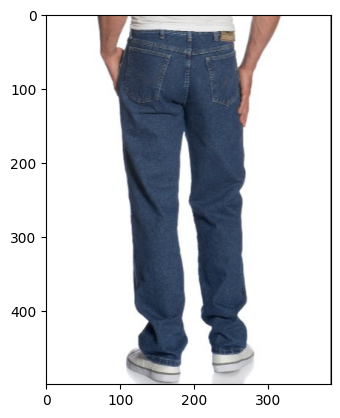

-----------------------------------------------------------------------
recommended product:


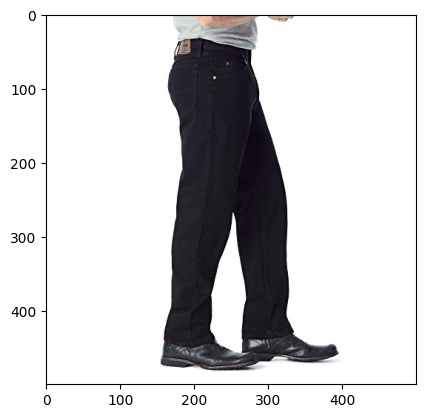

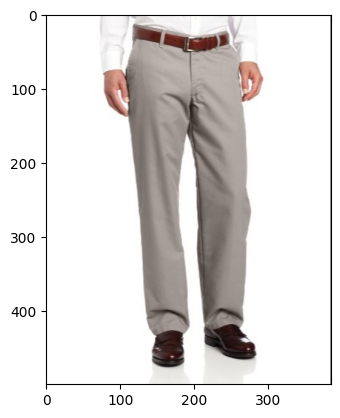

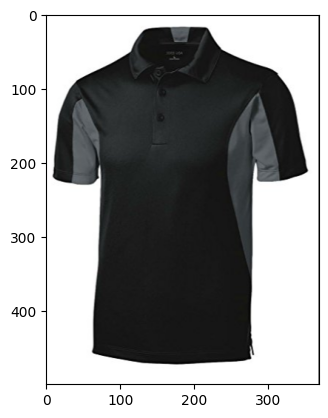

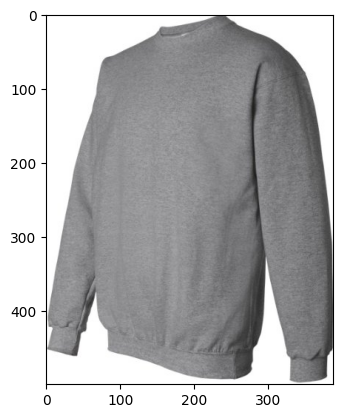

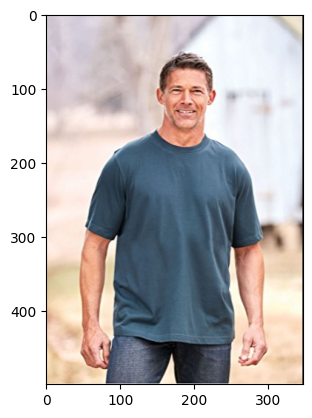

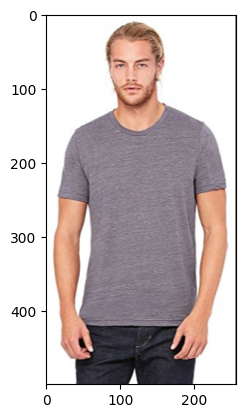

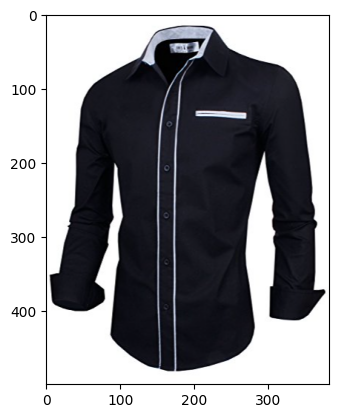

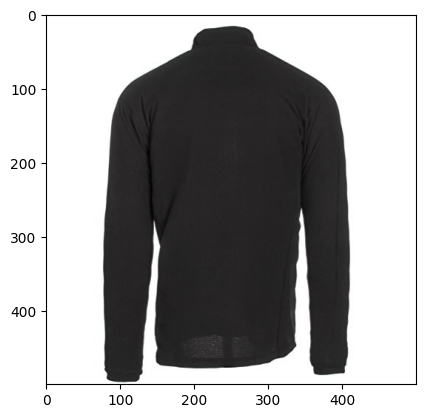

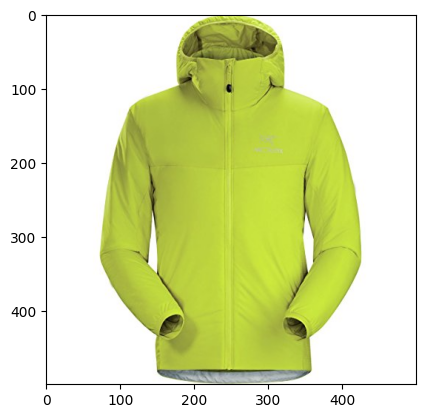

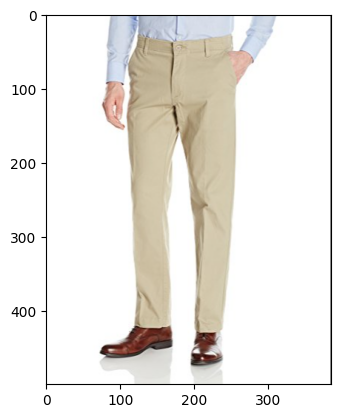

In [111]:
# nodes = pd.read_parquet(f'../Dataset/nodes_without_image.parquet')
# edges = pd.read_parquet(f'../Dataset/edges_without_image.parquet',engine='pyarrow')
recommended_products = recommend_top_k_products_based_on_link_scores(graph_loaded, 1, loaded_model,k=10)